In [1]:
#import necessary libraries
from torchtext.data import Field
from torchtext.data import TabularDataset
import pandas as pd
import re
import torch
import collections
import numpy as np
from torchtext.data import Iterator, BucketIterator
import json
import time
import tqdm

#output all items, not just last one
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

#set device
if torch.cuda.is_available():
    device= "cuda"
else:
    device = "cpu"  

In [2]:
class Articles(torch.utils.data.Dataset):
    def __init__(self, json_file):
        super().__init__()
        with open(json_file, "r") as data_file:
            self.examples = json.loads(data_file.read())
        self.tokenize()
    
    def __getitem__(self, idx):
        return self.examples[idx]
    
    def __len__(self):
        return len(self.examples)
    
    def tokenize(self):
        for idx, example in enumerate(self.examples):
            self.examples[idx]['text'] = re.findall('[\w]+', self.examples[idx]['text'].lower())
            self.examples[idx]['title'] = re.findall('[\w]+', self.examples[idx]['title'].lower())
    
    def create_weighted_sampler(self):
        prob = np.zeros(len(self))
        positive = sum(example['longform'] == 0 for example in self.examples)
        negative = len(self) - positive
        for idx, example in enumerate(self.examples):
            if example['longform'] == 0:
                prob[idx] = (positive/(len(self)))
            else:
                prob[idx] = (negative/(len(self)))
        return torch.utils.data.WeightedRandomSampler(weights=prob, num_samples=len(self), replacement=True)
    
    def create_dictionaries(self):
        counter = collections.Counter()
        url_counter = collections.Counter()
        urls = []

        for example in self.examples:
            counter.update(example['text'])
            counter.update(example['title'])
            urls.append(example['url'])

        url_counter.update(urls)
        word_to_id = {word: id for id, word in enumerate(counter.keys())}
        article_to_id = {word: id for id, word in enumerate(url_counter.keys())}
        return word_to_id, article_to_id
    
    def map_items(self, word_to_id, url_to_id):
        words = []
        articles = []
        labels = []
        for idx, example in enumerate(self.examples):
            self.examples[idx]['text'] = [word_to_id.get(word, len(word_to_id)) for word in example['text']]
            self.examples[idx]['title'] = [word_to_id.get(word, len(word_to_id)) for word in example['title']]
            self.examples[idx]['url'] = url_to_id.get(example['url'])
            
    def clone(self):
        return self

In [3]:
def create_merged_dictionaries(train, test, val, adv_):
    counter = collections.Counter()
    url_counter = collections.Counter()
    urls = []

    for example in train.examples + test.examples + val.examples + adv_.examples:
        counter.update(example['text'])
        counter.update(example['title'])
        urls.append(example['url'])

    url_counter.update(urls)
    word_to_id = {word: id for id, word in enumerate(counter.keys())}
    article_to_id = {word: id for id, word in enumerate(url_counter.keys())}
    return word_to_id, article_to_id

train_data = Articles("changed-data/train.json")
test_data = Articles("changed-data/test.json")
val_data = Articles("changed-data/validate.json")
adv_data = Articles("adv-data/adv-data.json")
print("Data Loaded")
# train_data = Articles("changed-data/debugdata/train_basic.json")
# test_data = Articles("changed-data/debugdata/test_basic.json")
# val_data = Articles("changed-data/debugdata/val_basic.json")

Data Loaded


In [4]:
final_word_ids,final_url_ids= create_merged_dictionaries(train_data, test_data, val_data, adv_data)
print("Dictionaries Created")

for dataset in [train_data, test_data, val_data, adv_data]:
    dataset.map_items(final_word_ids, final_url_ids);
    
print("Items mapped")

Dictionaries Created
Items mapped


In [5]:
with open("dictionaries/word_dictionary.json", "w") as file:
    json.dump(final_word_ids, file)

with open("dictionaries/article_dictionary.json", "w") as file:
    json.dump(final_url_ids, file)

In [6]:
list(final_url_ids.items())[-10:]

[('https://www.wired.com/story/clearview-ai-client-list-cerberus-malware-security-news/',
  123080),
 ('https://www.wired.com/story/plant-shutdowns-vital-truckers-more-car-news/',
  123081),
 ('https://www.wired.com/story/traffic-spreads-like-disease/', 123082),
 ('https://www.wired.com/story/tesla-cruising-investors-going-joyride/',
  123083),
 ('https://www.wired.com/story/opinion-to-end-the-pandemic-give-universal-testing-the-green-light/',
  123084),
 ('https://www.wired.com/story/code-obsessed-novelist-builds-writing-bot-the-plot-thickens/',
  123085),
 ('https://www.wired.com/story/travel-bans-and-quarantines-wont-stop-coronavirus/',
  123086),
 ('https://www.wired.com/story/sundar-pichai-on-google-maps-at-15/', 123087),
 ('https://www.wired.com/story/google-maps-jen-fitzpatrick-q-and-a/', 123088),
 ('https://www.wired.com/story/cisco-hack-vulnerability-locusts-africa/',
  123089)]

In [7]:
def collate_fn(examples):
    words = []
    articles = []
    labels = []
    for example in examples:
        words.append(list(set(example['text'])))
        articles.append(example['url'])
        labels.append(example['longform'])
    num_words = [len(x) for x in words]
    words = np.concatenate(words, axis=0)
    word_attributes = torch.tensor(words, dtype=torch.long)
    articles = torch.tensor(articles, dtype=torch.long)
    num_words.insert(0,0)
    num_words.pop(-1)
    attribute_offsets = torch.tensor(np.cumsum(num_words), dtype=torch.long)
    publications = torch.tensor([0])
    labels = torch.tensor(labels, dtype=torch.float)
    return publications, articles, word_attributes, attribute_offsets, labels

In [8]:
import torch.nn as nn

class InnerProduct(nn.Module):
    def __init__(self, n_publications, n_articles, n_attributes, emb_size, sparse, use_article_emb):
        super().__init__()
        self.emb_size = emb_size
        self.publication_embeddings = nn.Embedding(n_publications, emb_size, sparse=sparse)
        self.publication_bias = nn.Embedding(n_publications, 1, sparse=sparse)
        self.attribute_emb_sum = nn.EmbeddingBag(n_attributes, emb_size, mode='sum', sparse=sparse)
        self.attribute_bias_sum = nn.EmbeddingBag(n_attributes, 1, mode='sum', sparse=sparse)
        self.use_article_emb = use_article_emb
        if use_article_emb:
            self.article_embeddings = nn.Embedding(n_articles, emb_size, sparse=sparse)
            self.article_bias = nn.Embedding(n_articles, 1, sparse=sparse)
        self.use_article_emb = use_article_emb

    def reset_parameters(self):
        for module in [self.publication_embeddings, self.attribute_emb_sum]:
            scale = 0.07
            nn.init.uniform_(module.weight, -scale, scale)
        for module in [self.publication_bias, self.attribute_bias_sum]:
            nn.init.zeros_(module.weight)
        if self.use_article_emb:
            for module in [self.article_embeddings, self.article_bias]:
            # initializing article embeddings to zero to allow large batch sizes
            # nn.init.uniform_(module.weight, -scale, scale)
                nn.init.zeros_(module.weight)

    def forward(self, publications, articles, word_attributes, attribute_offsets, pairwise=False, return_intermediate=False):
        publication_emb = self.publication_embeddings(publications)
        attribute_emb = self.attribute_emb_sum(word_attributes, attribute_offsets)
        if self.use_article_emb:
            article_and_attr_emb = self.article_embeddings(articles) + attribute_emb
        else:
            article_and_attr_emb = attribute_emb
        attr_bias = self.attribute_bias_sum(word_attributes, attribute_offsets)
        publication_bias = self.publication_bias(publications)
        if pairwise:
          # for every publication, compute inner product with every article
          # (publications, emb_size) x (emb_size, articles) -> (publications, articles)
            inner_prod = publication_emb @ article_and_attr_emb.t()
          # broadcasting across publication dimension
            logits = inner_prod + publication_bias
          # broadcast across article dimension
            logits += attr_bias.t()
            if self.use_article_emb:
                logits += self.article_bias(articles).t()
        else:
              # for every publication, only compute inner product with corresponding minibatch element
              # (batch_size, 1, emb_size) x (batch_size, emb_size, 1) -> (batch_size, 1)
              # logits = torch.bmm(publication_emb.view(-1, 1, self.emb_size), 
              #                    (article_and_attr_emb).view(-1, self.emb_size, 1)).squeeze()
            inner_prod = (publication_emb * article_and_attr_emb).sum(-1)
            logits = inner_prod + attr_bias.squeeze() + publication_bias.squeeze()
            if self.use_article_emb:
                logits += self.article_bias(articles).squeeze()
        if return_intermediate:
            return logits, publication_emb, attribute_emb
        else:
            return logits
        

In [9]:
train_weight_sampler = train_data.create_weighted_sampler()
train_batch_sampler = torch.utils.data.BatchSampler(train_weight_sampler, 64, drop_last=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_sampler=train_batch_sampler, collate_fn=collate_fn, pin_memory=True)

In [10]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data), collate_fn=collate_fn, pin_memory=True)

In [11]:
from tqdm.notebook import tqdm

kwargs = dict(n_publications=1, 
              n_articles=len(final_url_ids), 
              n_attributes=len(final_word_ids), 
              emb_size=100, sparse=False, 
              use_article_emb=False)
model = InnerProduct(**kwargs)
model.reset_parameters()
model.to(device)

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4,momentum=0.9)

val_batch = next(iter(val_loader))
val_publications, val_articles, val_word_attributes, val_attribute_offsets, val_labels = val_batch
val_publications = val_publications.to(device)
val_articles = val_articles.to(device)
val_word_attributes = val_word_attributes.to(device)
val_attribute_offsets = val_attribute_offsets.to(device)
val_labels = val_labels.to(device)
print(len(val_labels))
model.train() # turn on training mode
check=True

while check: 
    for step,batch in enumerate(tqdm(cycle(train_loader))):
        optimizer.zero_grad();
        publications, articles, word_attributes, attribute_offsets, labels = batch
        publications = publications.to(device)
        articles = articles.to(device)
        word_attributes = word_attributes.to(device)
        attribute_offsets = attribute_offsets.to(device)
        labels = labels.to(device)
        logits = model(publications, articles, word_attributes, attribute_offsets)
        L = loss(logits, labels)
        L.backward();
        optimizer.step();
        if step % 50 == 0 and step % 400 != 0:
            model.eval();
            preds = model(val_publications, val_articles, val_word_attributes, val_attribute_offsets)
            sorted_preds, indices = torch.sort(preds, descending=True)
            correct_10=0
            correct_100=0
            for i in range(0,10):
                if val_labels[indices[i]] == 1:
                    correct_10 += 1
            for i in range(0, 100):
                if val_labels[indices[i]] == 1:
                    correct_100 += 1
            print("Top 10: ", correct_10, "/10 or ", (correct_10*10), "%")
            print("Top 100: ", correct_100, "/100 or", correct_100, "%")
            model.train();
        if step != 0 and step % 400 == 0:
            model.eval();
            preds = model(val_publications, val_articles, val_word_attributes, val_attribute_offsets)
            sorted_preds, indices = torch.sort(preds, descending=True)
            df = pd.DataFrame(columns=['title', 'url', 'text','longform', 'prediction'])
            links = list(final_url_ids.keys())
            for i in range(0, 1000):
                example = val_data[indices[i]]
                prediction = sorted_preds[i].item()
                text = []
                for x in example['title']:
                    text.append(next((word for word, numero in final_word_ids.items() if numero == x), None))
                    title = ""
                for word in text:
                    title += word
                    title += " "
                short_text = list(set(example['text']))
                url = links[example['url']]
                longform = example['longform']
                df.loc[i] = [title, url, short_text, longform, prediction]
            df.head()
            df.to_csv("top-1000.csv")
            check=False
            break

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

11390


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  9 /10 or  90 %
Top 100:  65 /100 or 65 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  99 /100 or 99 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  99 /100 or 99 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  99 /100 or 99 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

,title,url,text,longform,prediction
0,the transformation of johnny spain,http://www.chipbrown.net/articles/spain.htm,"[0, 3, 4, 7, 9, 11, 12, 8206, 15, 114706, 22, ...",1,22.966122
1,the killer cadets,http://www.texasmonthly.com/articles/the-kille...,"[0, 1, 3, 4, 7, 9, 12, 13, 14, 15, 23, 25, 26,...",1,22.947670
2,flesh and blood,http://www.texasmonthly.com/story/flesh-and-blood,"[0, 3, 4, 5, 7, 8199, 9, 11, 12, 13, 15, 22, 2...",1,22.419840
3,the life and death of richard brautigan,http://www.rollingstone.com/culture/features/t...,"[0, 3, 4, 7, 9, 11, 12, 16396, 13, 15, 21, 22,...",1,22.223270
4,casualties of war,http://www.lamag.com/features/casualties-of-war/,"[0, 1, 3, 4, 7, 8, 9, 12, 13, 15, 21, 22, 23, ...",1,21.793623


In [12]:
adv_loader = torch.utils.data.DataLoader(adv_data, batch_size=len(adv_data), collate_fn=collate_fn, pin_memory=True)

adv_batch = next(iter(adv_loader))
adv_publications, adv_articles, adv_word_attributes, adv_attribute_offsets, adv_labels = adv_batch
adv_publications = adv_publications.to(device)
adv_articles = adv_articles.to(device)
adv_word_attributes = adv_word_attributes.to(device)
adv_attribute_offsets = adv_attribute_offsets.to(device)
adv_labels = adv_labels.to(device)

model.eval()
adv_preds = model(adv_publications, adv_articles, adv_word_attributes, adv_attribute_offsets)
adv_sorted_preds, locations = torch.sort(adv_preds, descending=True)
adv_sort = pd.DataFrame(columns=['title', 'url', 'text','longform', 'prediction'])
for i in range(0, 1000):
    example = adv_data[locations[i]]
    prediction = adv_sorted_preds[i].item()
    text = []
    for x in example['title']:
        text.append(next((word for word, numero in final_word_ids.items() if numero == x), "unk"))
        title = ""
    for word in text:
        title += word
        title += " "
    short_text = list(set(example['text']))
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    longform = example['longform']
    adv_sort.loc[i] = [title, url, short_text, longform, prediction]
adv_sort.head()

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

,title,url,text,longform,prediction
0,the strange and mysterious death of mrs jerry ...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 8199, 9, 11, 12, 13, 15, 8208,...",0,26.706547
1,tom wolfe the rolling stone interview,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 9, 11, 12, 13, 15, 17, 22, 23,...",0,20.745760
2,the martyrdom of brad will,https://www.rollingstone.com/culture/culture-f...,"[0, 3, 4, 7, 9, 16393, 11, 12, 13, 15, 16402, ...",0,17.632528
3,bert kreischer the undergraduate,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 9, 12, 16397, 15, 24592, 16403...",0,16.678162
4,paul bowles the rolling stone interview,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 376832, 3, 4, 376833, 376834, 7, 8199, ...",0,16.244732


In [13]:
total_adv = pd.concat([df, adv_sort], ignore_index=True)
sorted_total_adv = total_adv.sort_values(by='prediction', ascending=False)

In [14]:
sorted_total_adv.to_csv("ranked-adv.csv", index=False)

In [15]:
sorted_total_adv.text.head()

1000    [0, 1, 3, 4, 7, 8199, 9, 11, 12, 13, 15, 8208,...
0       [0, 3, 4, 7, 9, 11, 12, 8206, 15, 114706, 22, ...
1       [0, 1, 3, 4, 7, 9, 12, 13, 14, 15, 23, 25, 26,...
2       [0, 3, 4, 5, 7, 8199, 9, 11, 12, 13, 15, 22, 2...
3       [0, 3, 4, 7, 9, 11, 12, 16396, 13, 15, 21, 22,...
Name: text, dtype: object

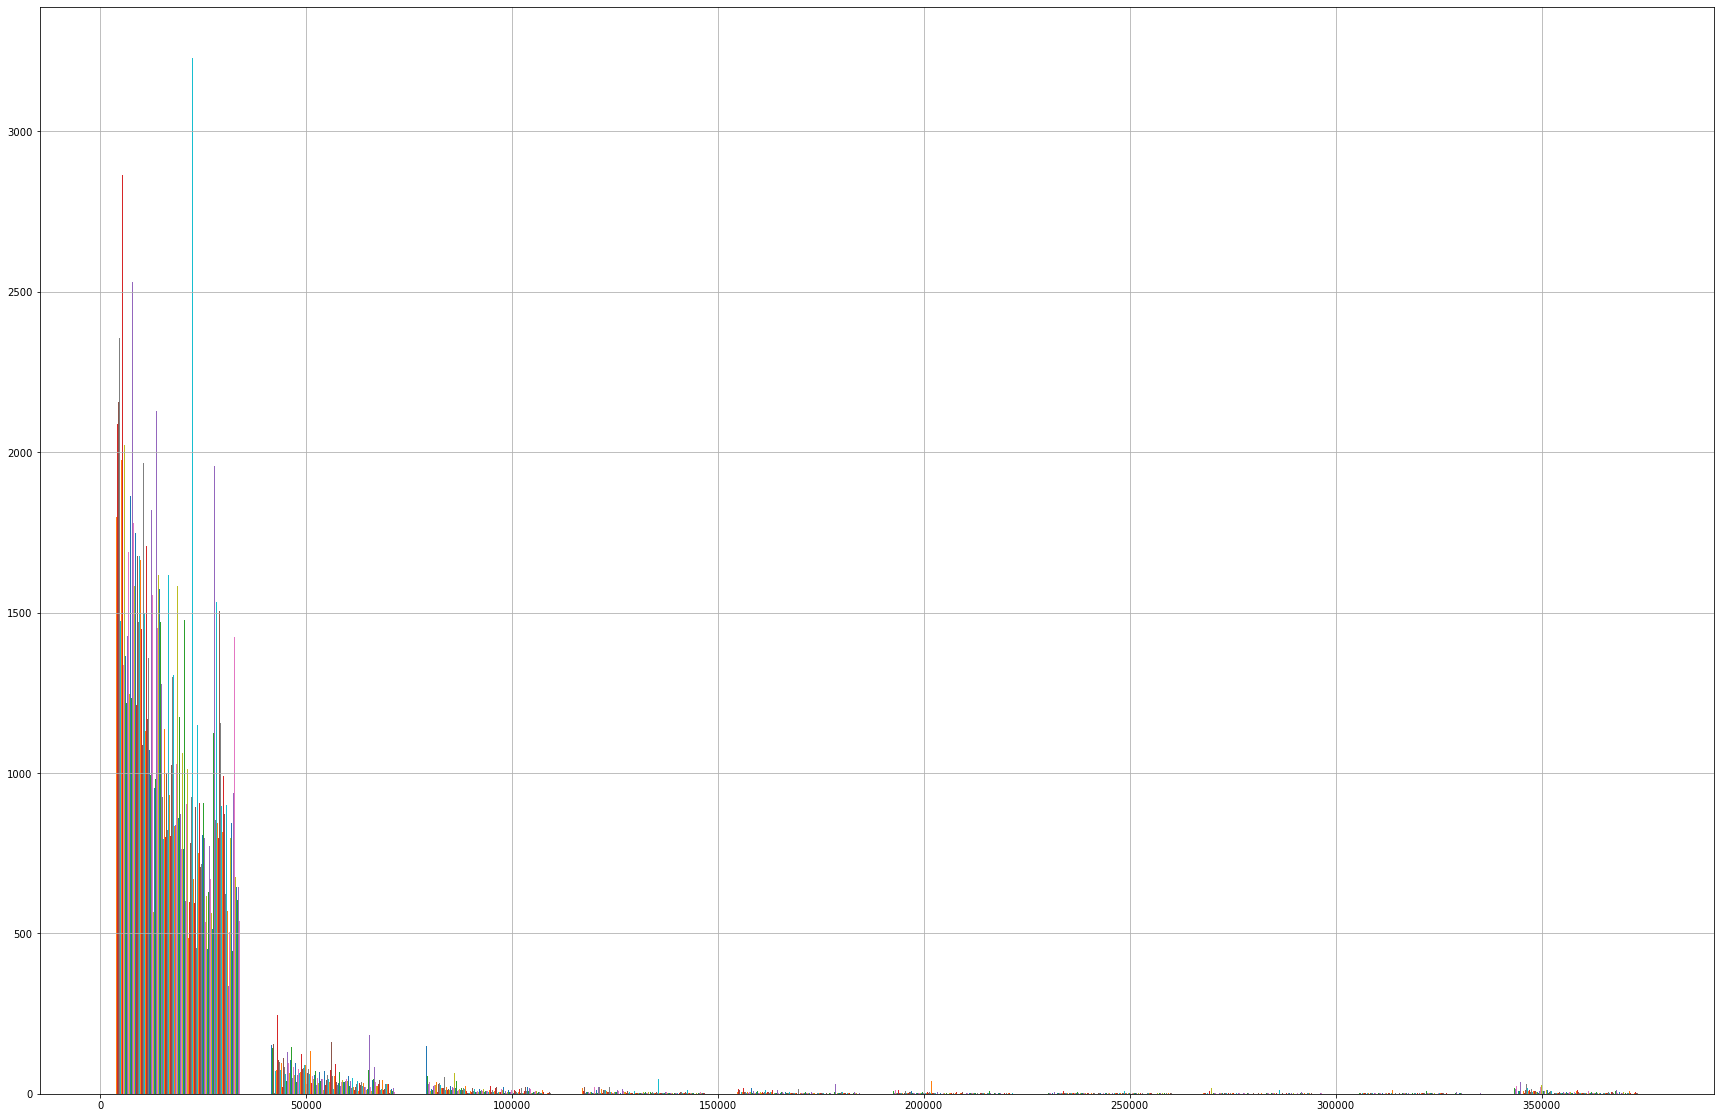

In [16]:
sorted_total_adv[sorted_total_adv.url.str.contains("rollingstone")].text.hist(figsize=(30,20))

In [ ]:
counter = collections.Counter()
for i in range(0, 2000):
    sorted_total_adv['text'][i] = list(sorted_total_adv['text'][i])
    counter.update(sorted_total_adv['text'][i])

rolling_df = sorted_total_adv[sorted_total_adv.url.str.contains("rollingstone")].reset_index(drop=True)
rollingcounter = collections.Counter()
for i in range(0, len(rolling_df)):
    rolling_df['text'][i] = list(rolling_df['text'][i])
    rollingcounter.update(rolling_df['text'][i])
    
longform_train_counter = collections.Counter()
longform_train_article_count = 0
for example in train_data.examples:
    if example['longform'] == 1:
        longform_train_article_count += 1
        longform_train_counter.update(list(set(example['text'])))

In [28]:
longform_train_counter.most_common()[:10]

[(7, 7135),
 (112, 7125),
 (3, 7111),
 (85, 7094),
 (37, 7085),
 (56, 7084),
 (78, 7029),
 (12, 7024),
 (66, 7016),
 (145, 7010)]

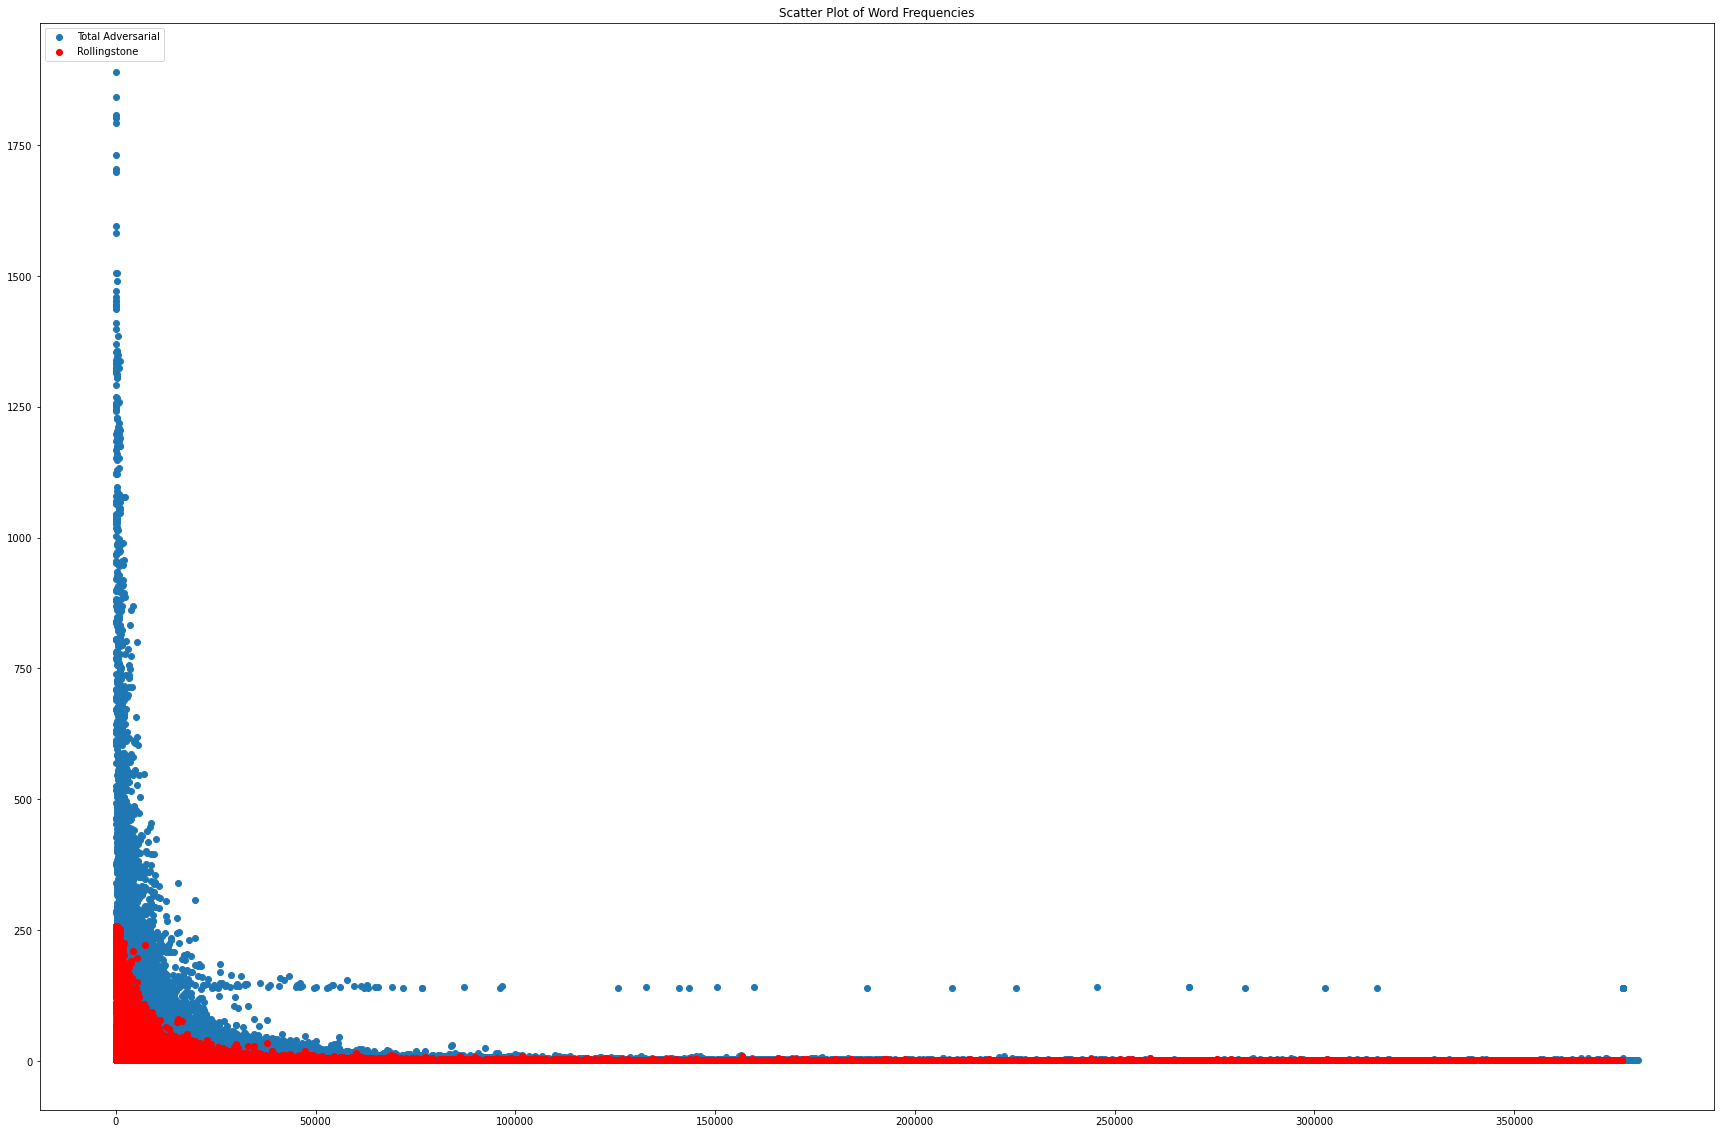

In [32]:
#word occurrence counts for adversarial set as a whole and specifically rollingstone articles
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
plt.scatter(*zip(*counter.most_common()), label="Total Adversarial")
plt.scatter(*zip(*rollingcounter.most_common()), color="red", label="Rollingstone")
plt.legend(loc='upper left');
plt.title("Scatter Plot of Word Frequencies")
plt.show();

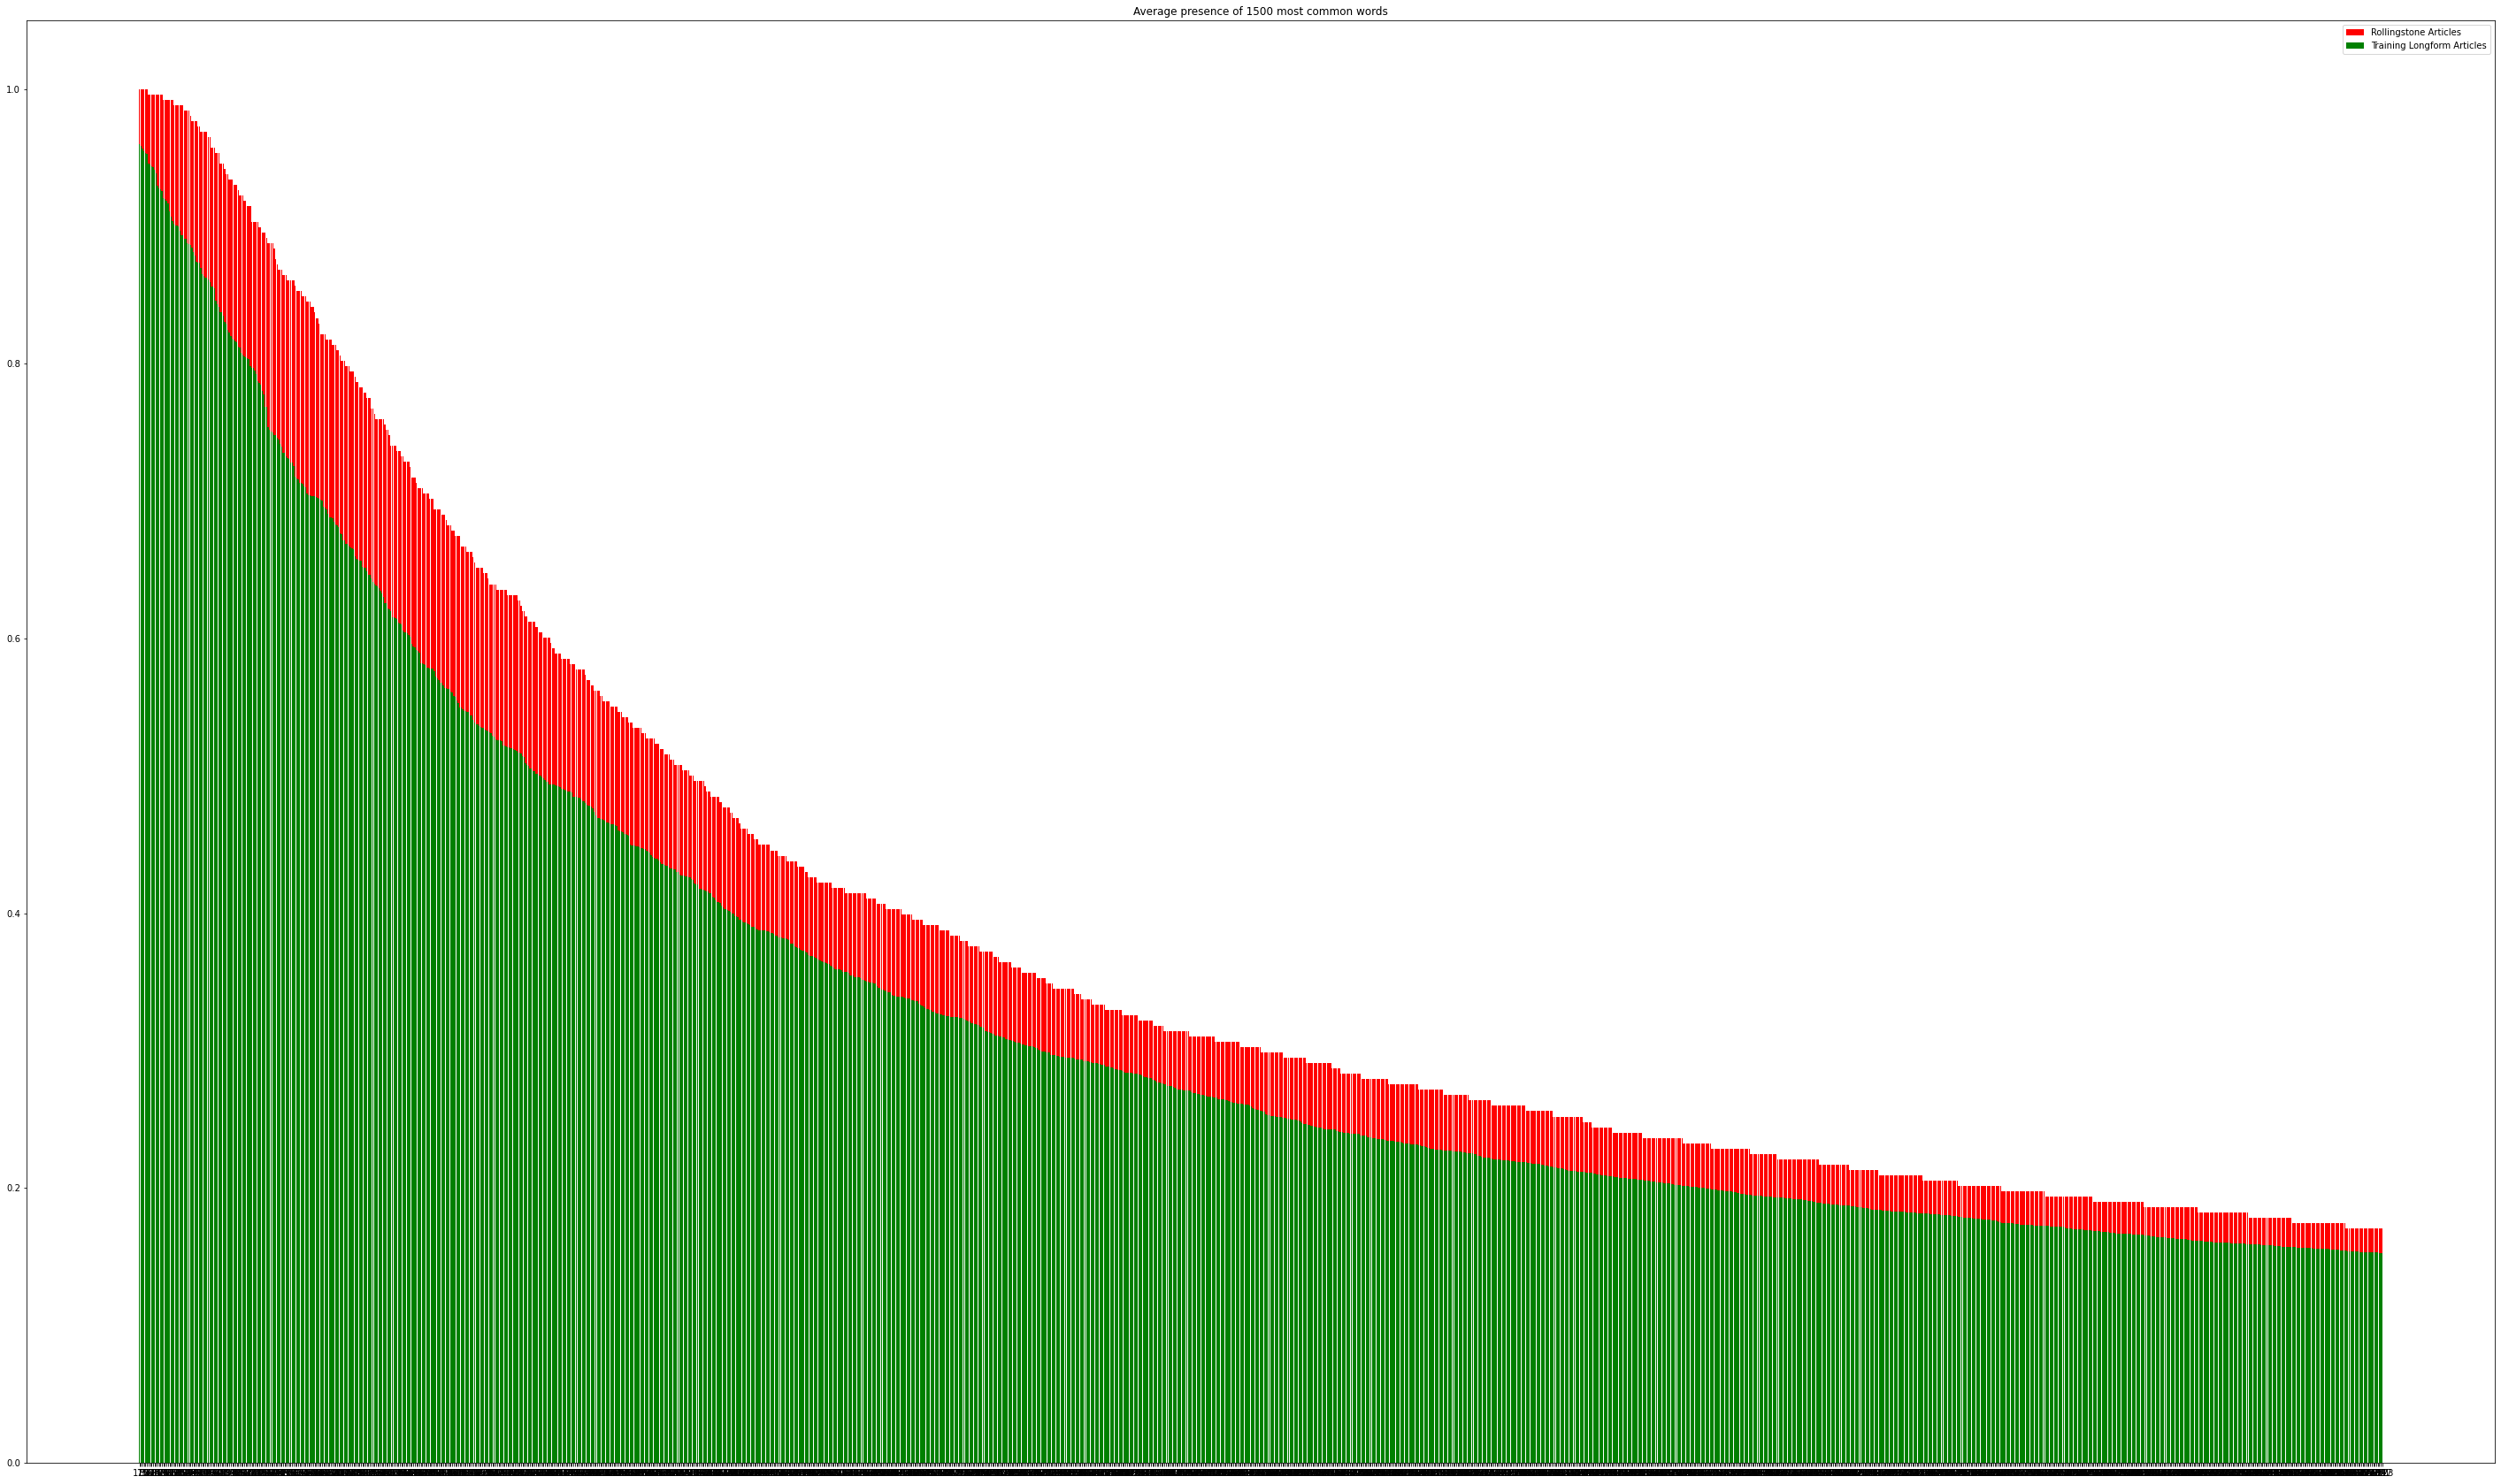

In [33]:
plt.figure(figsize=(50,30))
word_places = list(zip(*rollingcounter.most_common()))[0][:1500]
freqs = list(zip(*rollingcounter.most_common()))[1][:1500]
freqs = [x/(len(rolling_df)) for x in freqs]
x_pos = np.arange(len(word_places))
plt.bar(x_pos, freqs, color="red", label="Rollingstone Articles");
plt.xticks(x_pos, word_places);
word_places = list(zip(*longform_train_counter.most_common()))[0][:1500]
freqs = list(zip(*longform_train_counter.most_common()))[1][:1500]
freqs = [x/(longform_train_article_count) for x in freqs]
x_pos = np.arange(len(word_places))
plt.bar(x_pos, freqs, color="green", label="Training Longform Articles");
plt.xticks(x_pos, word_places);
plt.legend(loc='upper right');
plt.title("Average presence of 1500 most common words")
plt.show();

In [34]:
#Getting inner product values from embedding multiplication with each word attribute
publication_emb = model.publication_embeddings.weight.data[0].cpu().numpy()
word_emb = model.attribute_emb_sum.weight.data.cpu().numpy()
word_emb.shape
inner_products = (publication_emb * word_emb).sum(axis=1)

(380917, 100)

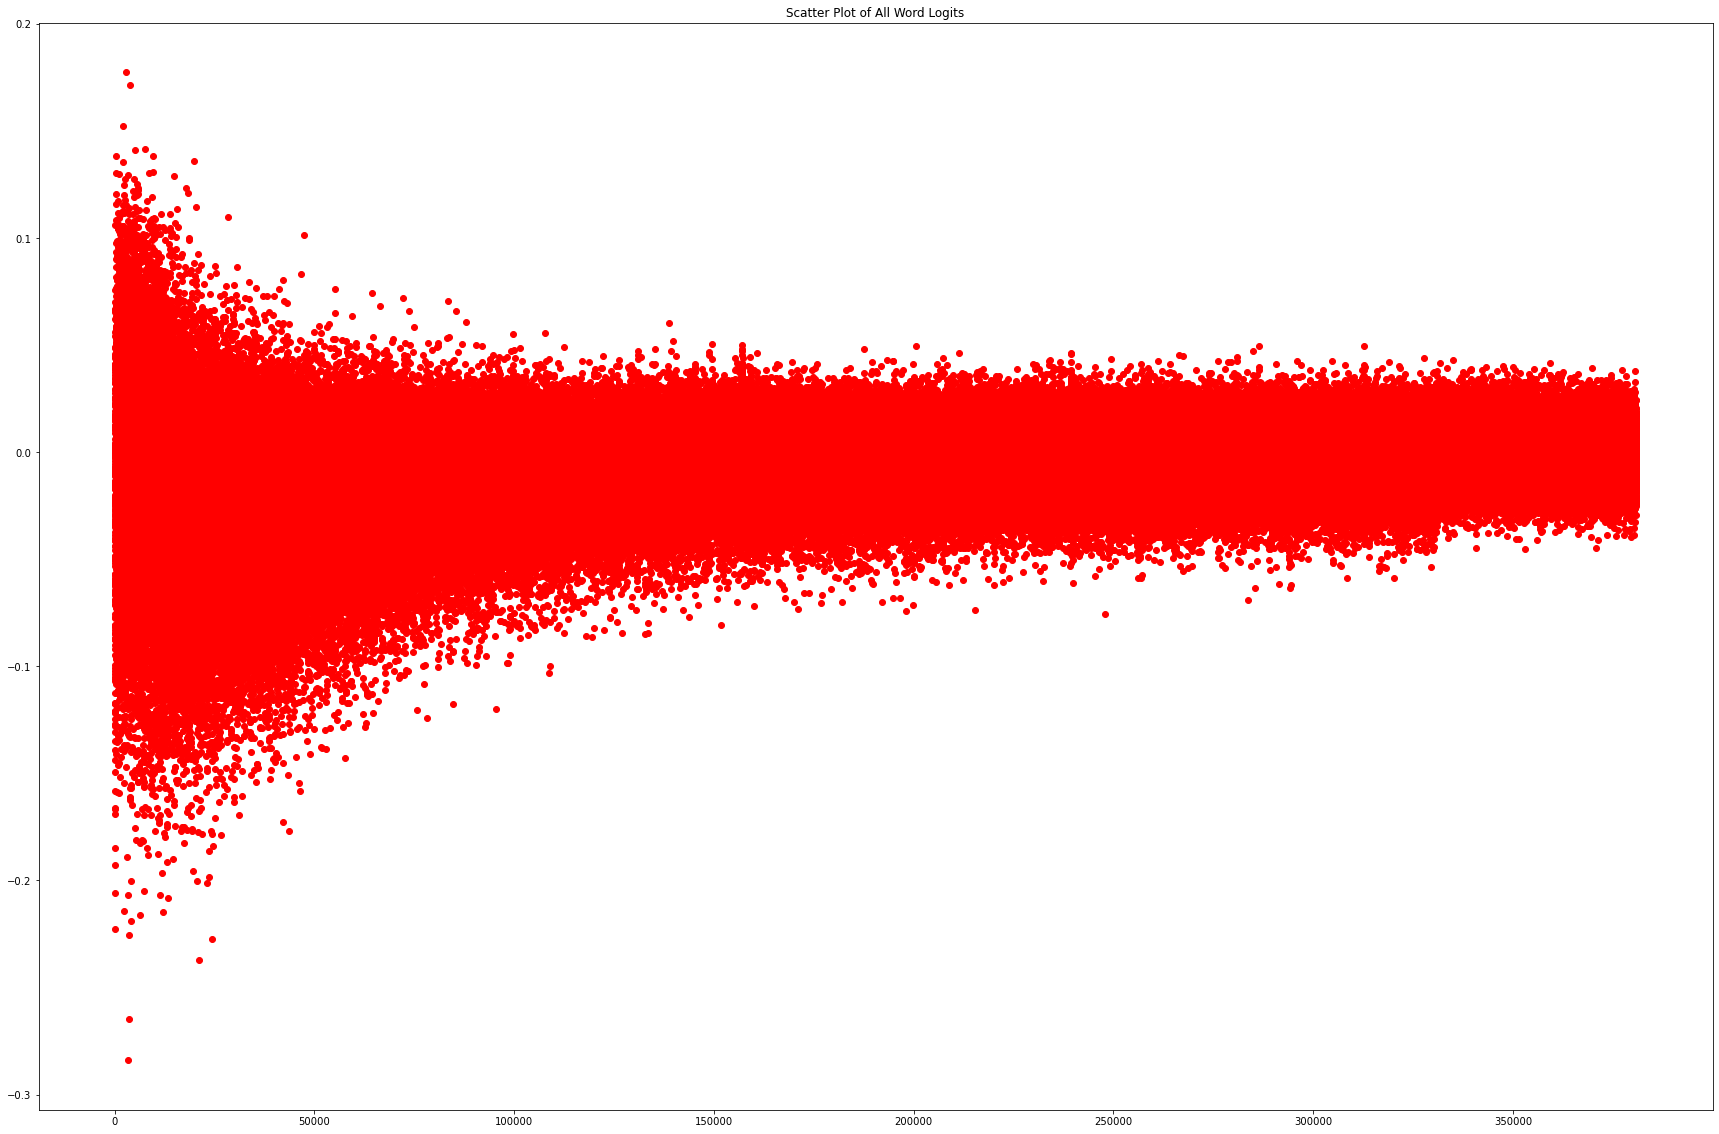

In [61]:
plt.figure(figsize=(30,20))
plt.scatter(*zip(*enumerate(inner_products)), color="red")
plt.title("Scatter Plot of All Word Logits")
plt.show();

In [59]:
sorted_product_idx = np.argsort(inner_products)
most_weighted = []
least_weighted = []
for x in sorted_product_idx[-1000:]:
    most_weighted.append((x, inner_products[x]))
for x in sorted_product_idx[:1000]:
    least_weighted.append((x, inner_products[x]))
extreme_weighted = most_weighted + least_weighted

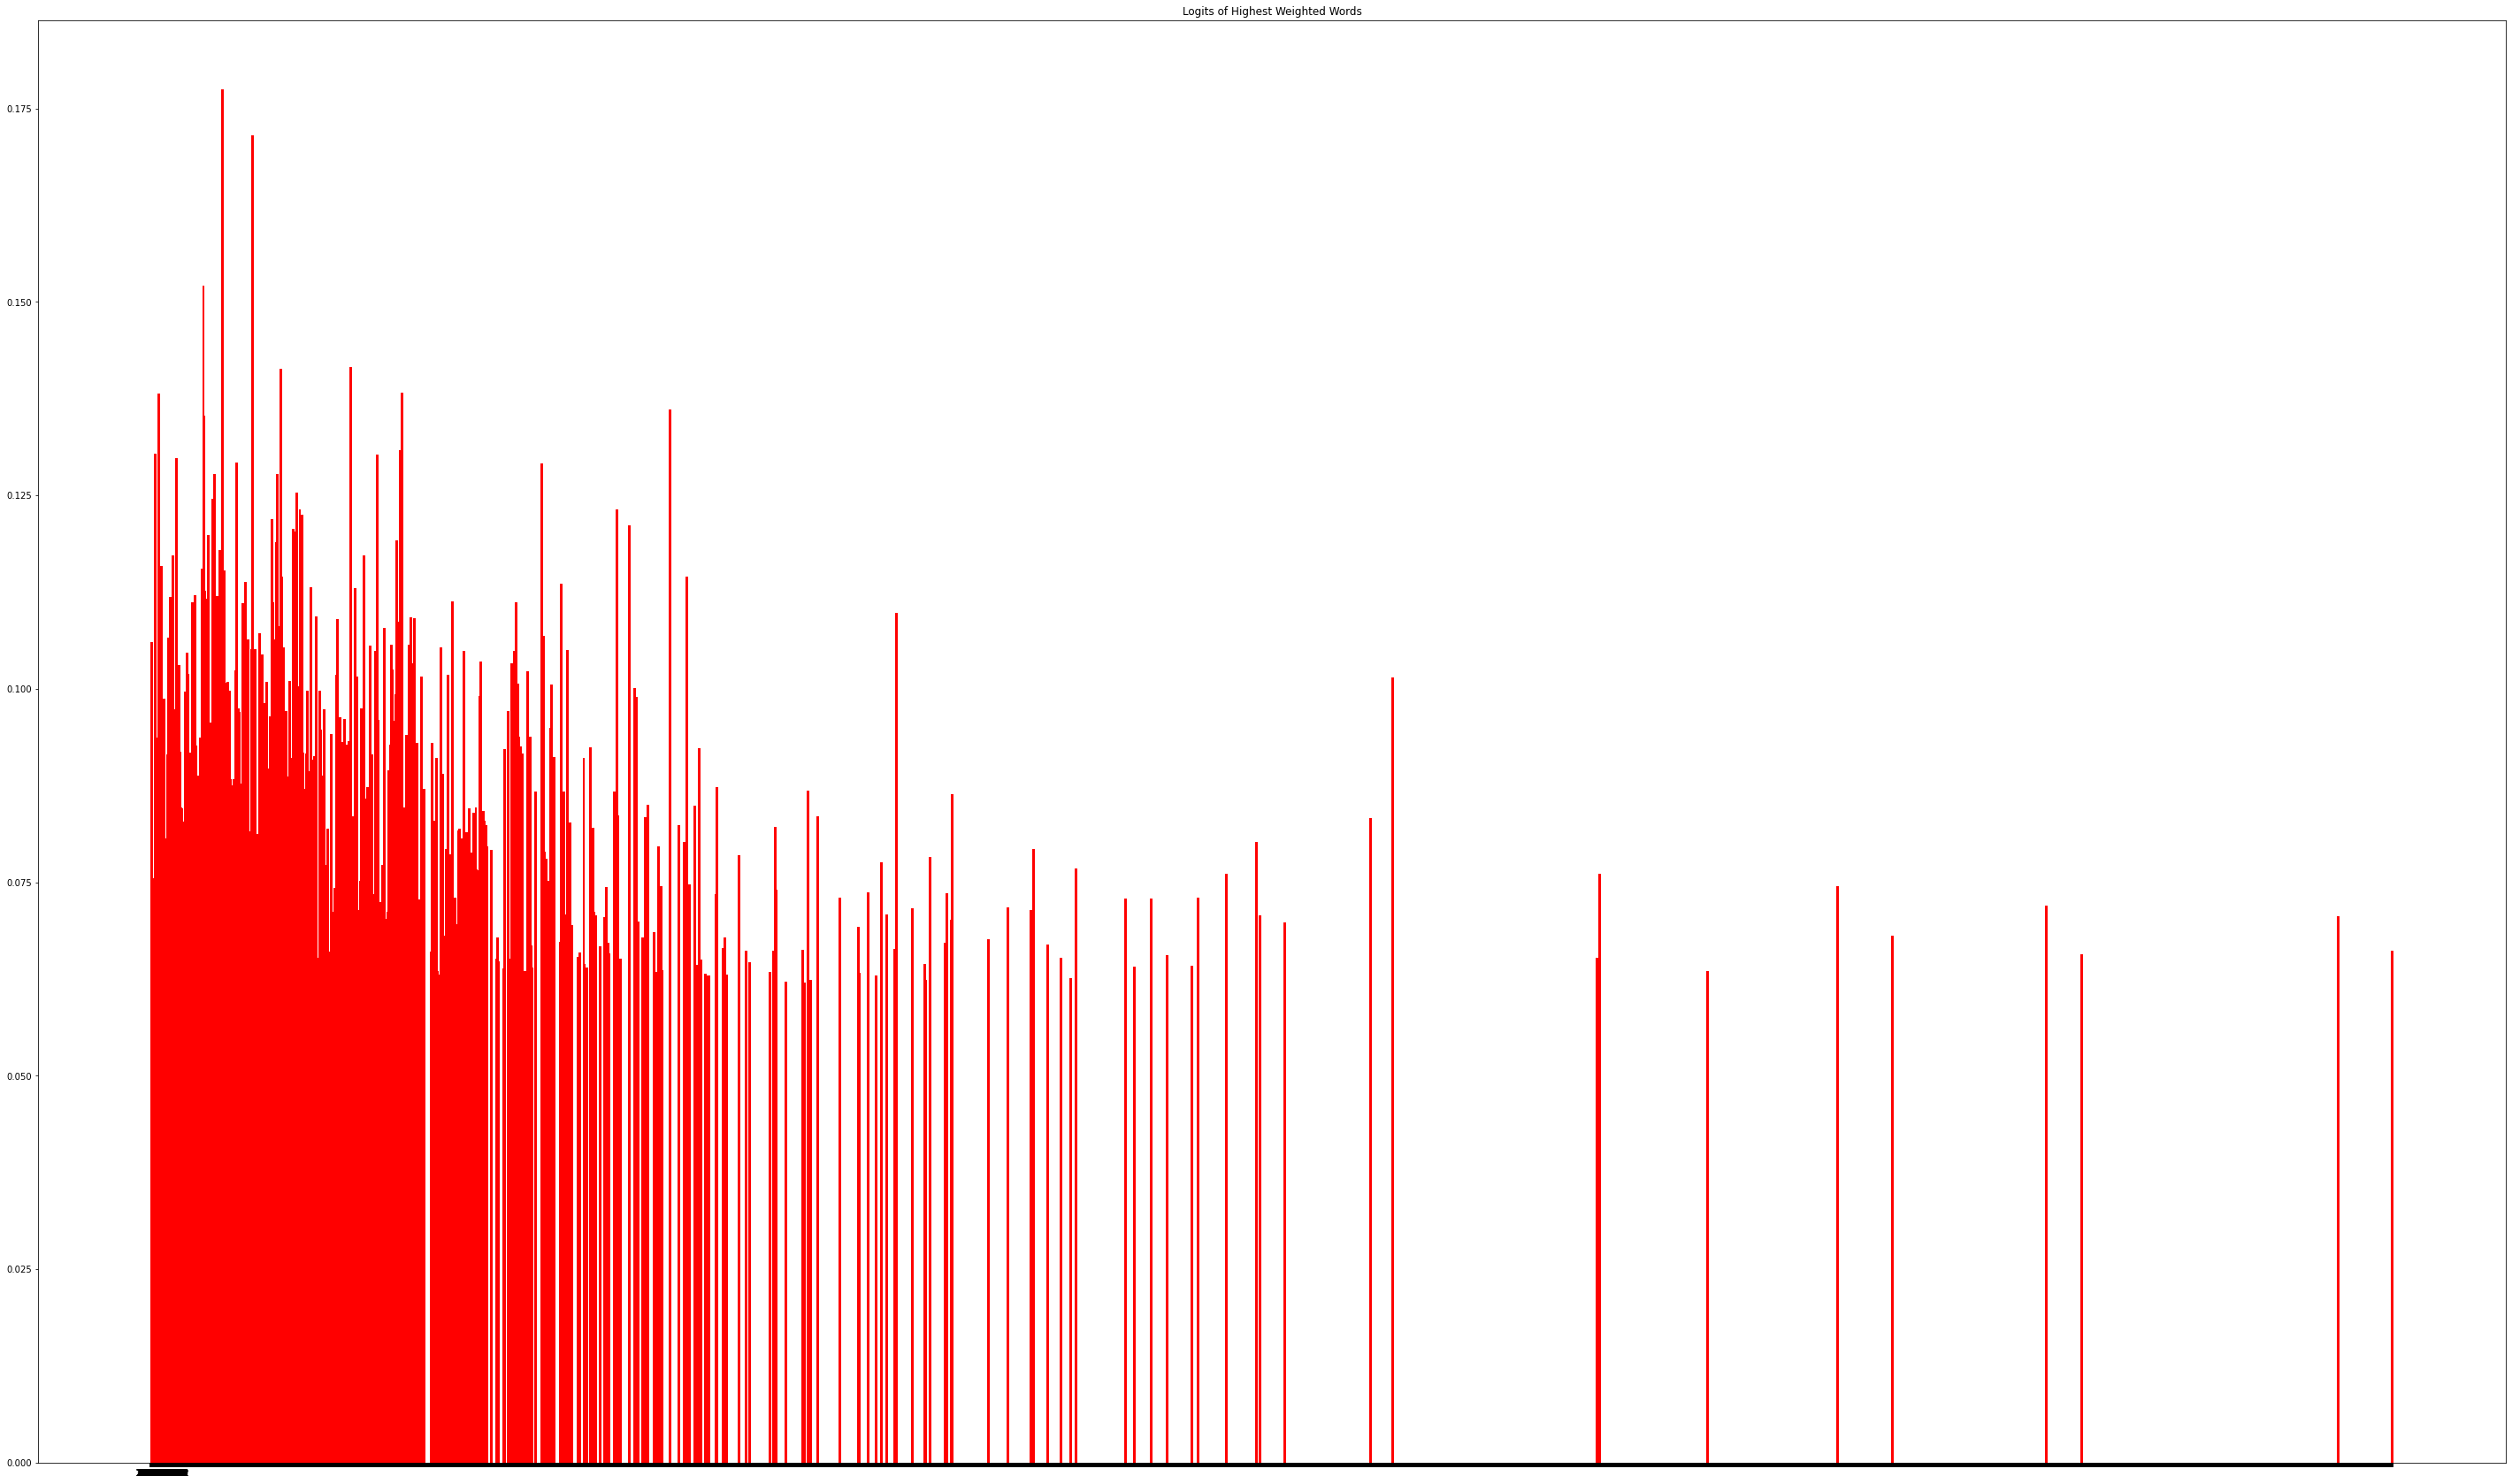

In [59]:
word_idx = list(zip(*most_weighted))[0]
weights = list(zip(*most_weighted))[1]
x_pos = np.arange(max(word_idx))
plt.figure(figsize=(50,30))
plt.bar(word_idx, weights, color="red", width=100, align="center")
plt.title("Logits of Highest Weighted Words")
plt.xticks(x_pos, word_idx)
plt.show();

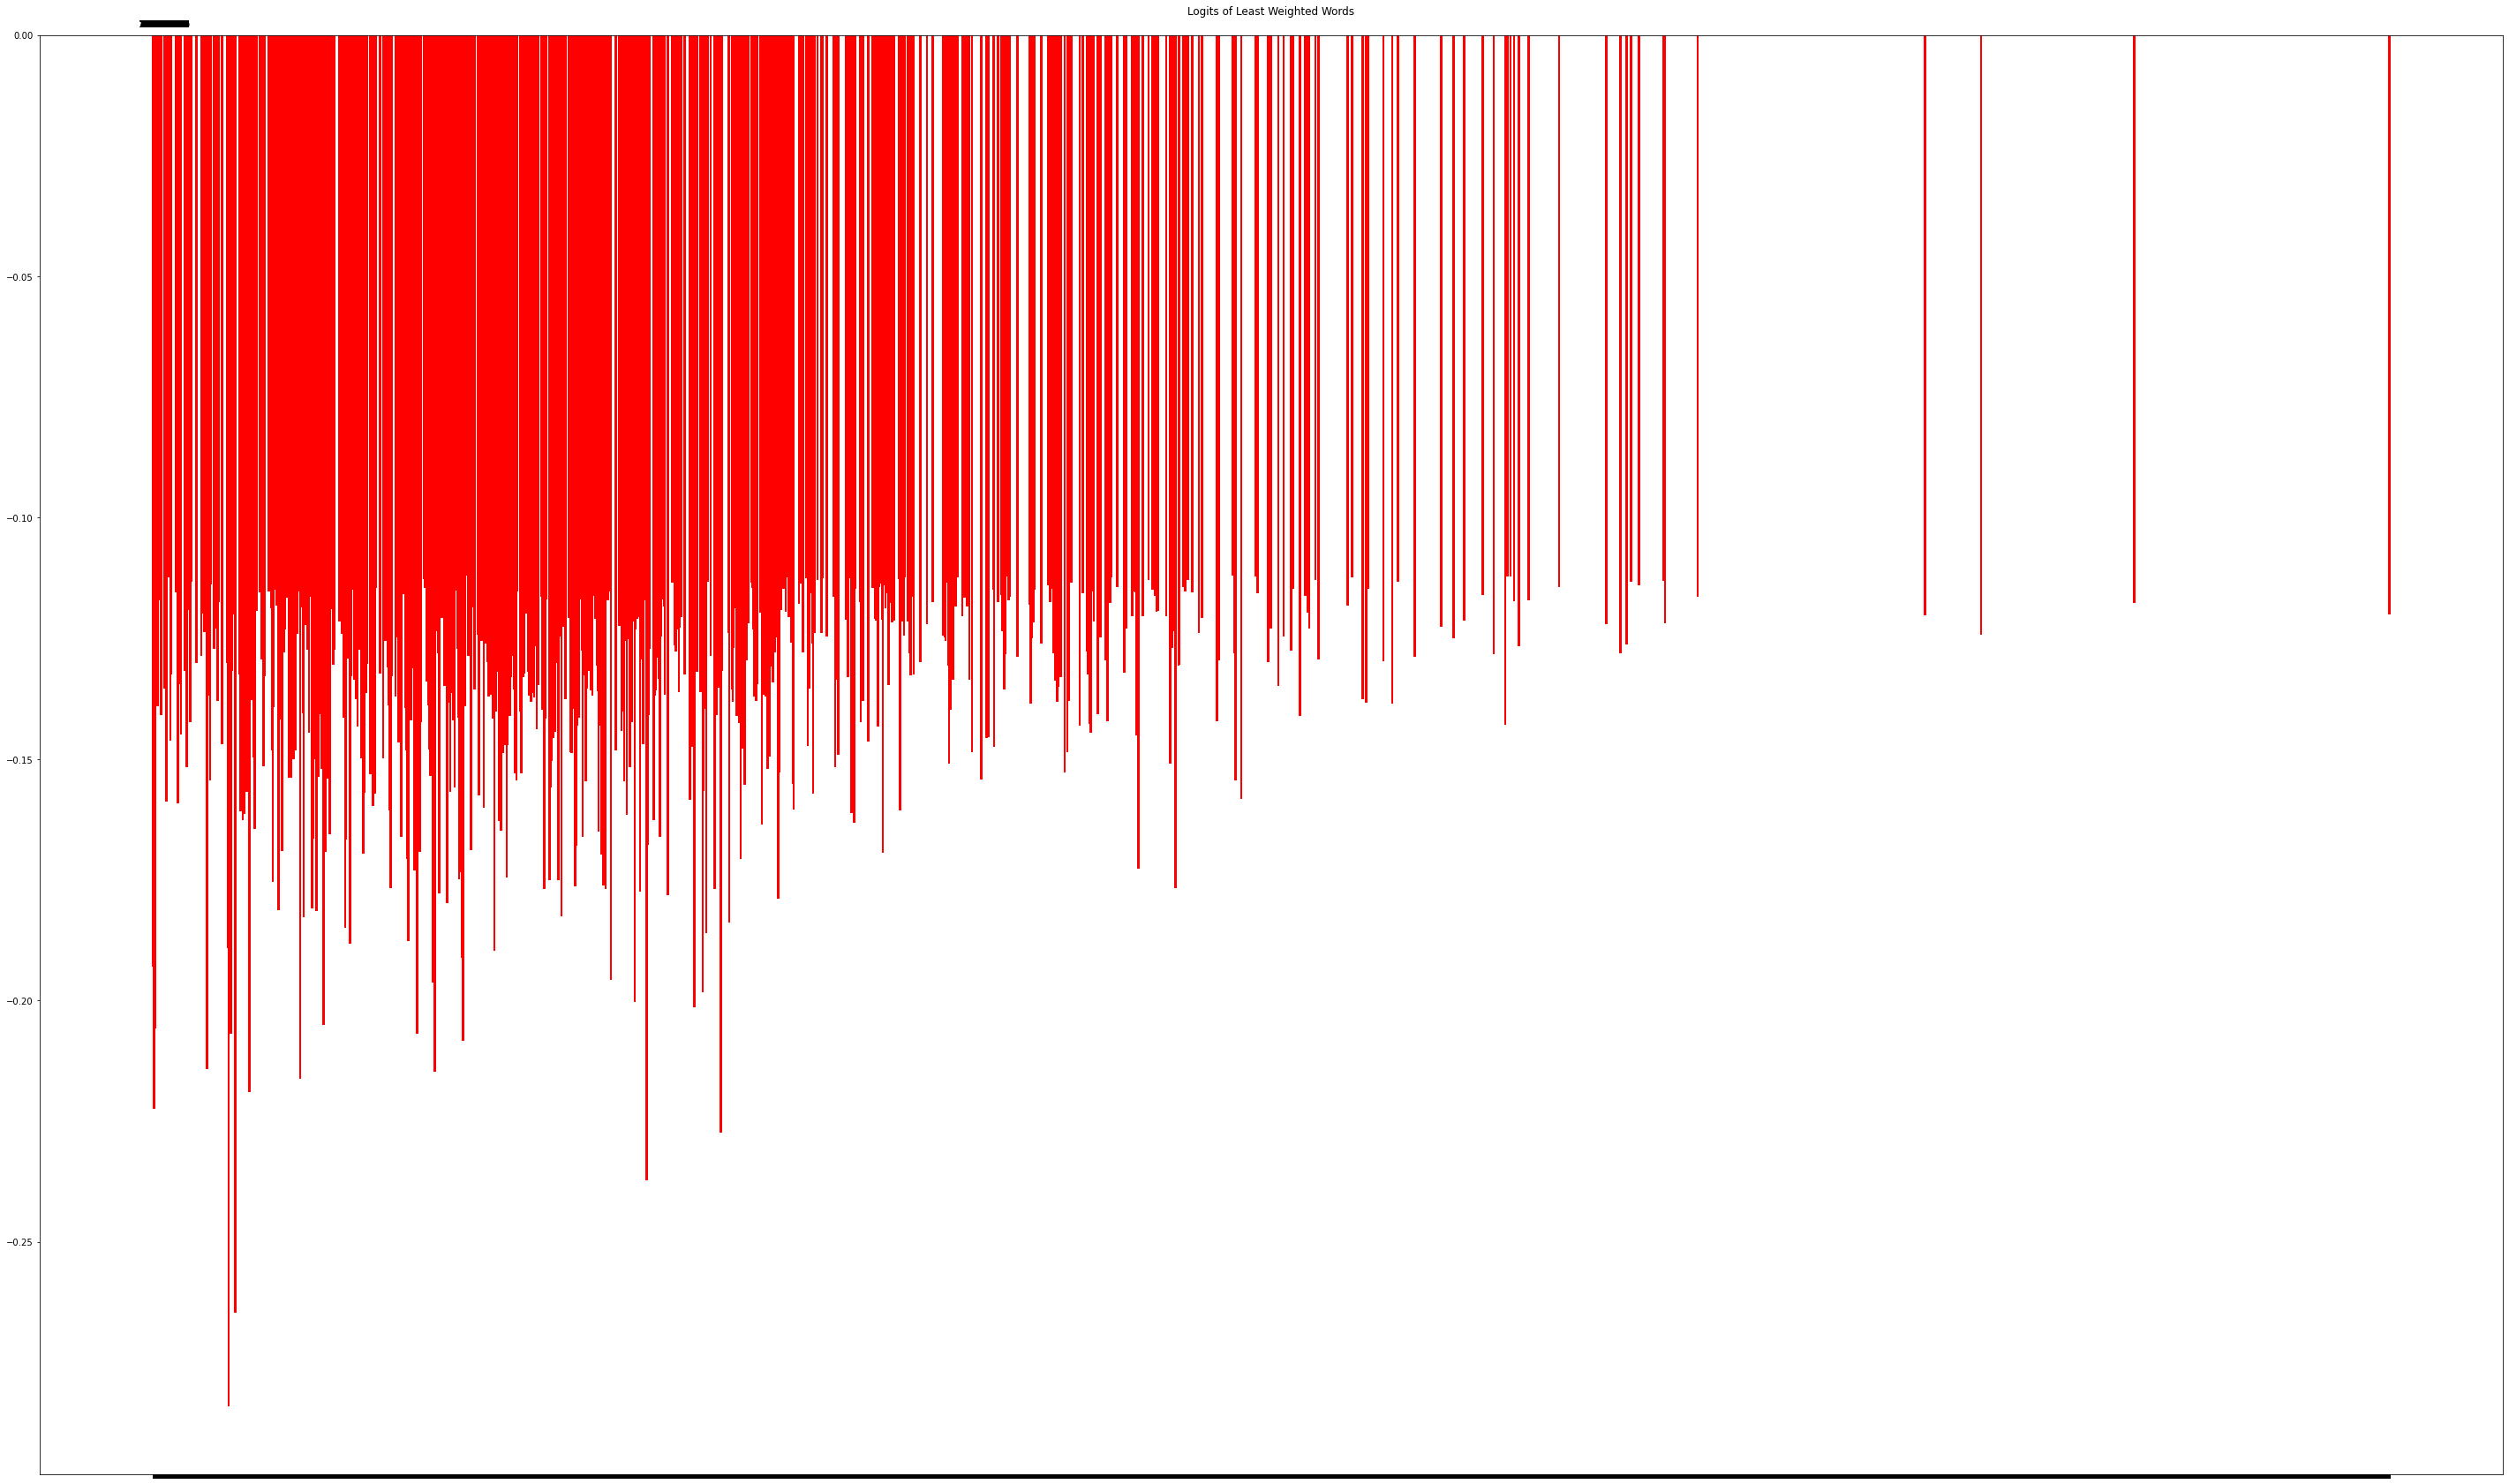

In [60]:
word_idx = list(zip(*least_weighted))[0]
weights = list(zip(*least_weighted))[1]
x_pos = np.arange(max(word_idx))
plt.figure(figsize=(50,30))
plt.bar(word_idx, weights, color="red", width=100, align="center")
plt.title("Logits of Least Weighted Words")
plt.tick_params(labelbottom=False,labeltop=True)
plt.xticks(x_pos, word_idx)
plt.show();

In [73]:
print("Heaviest Weighted")
print("------------------------")
for x in sorted_product_idx[-50:]:
    word = next((word for word, numero in final_word_ids.items() if numero == x), "unk")
    print("Word: ", word, "  -------- ", inner_products[x])

Heaviest Weighted
------------------------
Word:  inner   --------  0.11132408
Word:  style   --------  0.11162883
Word:  met   --------  0.11189681
Word:  whose   --------  0.11202057
Word:  neck   --------  0.11209933
Word:  wore   --------  0.11263298
Word:  described   --------  0.11265547
Word:  hall   --------  0.11302635
Word:  represented   --------  0.11313781
Word:  crowd   --------  0.11361181
Word:  upstairs   --------  0.11386701
Word:  beard   --------  0.1144915
Word:  aside   --------  0.11453394
Word:  central   --------  0.115317956
Word:  magazine   --------  0.11552535
Word:  grew   --------  0.11590753
Word:  catherine   --------  0.11721148
Word:  thus   --------  0.117294654
Word:  touch   --------  0.11794565
Word:  distance   --------  0.11894879
Word:  copy   --------  0.11918825
Word:  deep   --------  0.11986202
Word:  legs   --------  0.120313086
Word:  military   --------  0.12043972
Word:  weight   --------  0.12058799
Word:  shirt   --------  0.12065598


In [74]:
sorted_product_idx = np.argsort(inner_products)
print("Least Weighted")
print("------------------------")
for x in sorted_product_idx[:50]:
    word = next((word for word, numero in final_word_ids.items() if numero == x), "unk")
    print("Word: ", word, "  -------- ", inner_products[x])

Least Weighted
------------------------
Word:  google   --------  -0.28399795
Word:  photograph   --------  -0.2646068
Word:  sexism   --------  -0.23734091
Word:  firstperson   --------  -0.22740173
Word:  afp   --------  -0.22559376
Word:  vox   --------  -0.22244339
Word:  2030   --------  -0.21891627
Word:  emmanuel   --------  -0.21616009
Word:  youngest   --------  -0.21478744
Word:  fiscal   --------  -0.21422611
Word:  macron   --------  -0.20838766
Word:  opposes   --------  -0.20695466
Word:  pinterest   --------  -0.20690855
Word:  the   --------  -0.20584676
Word:  cybersecurity   --------  -0.20506634
Word:  wang   --------  -0.2013959
Word:  epa   --------  -0.20032755
Word:  fuels   --------  -0.20029822
Word:  challenger   --------  -0.19821471
Word:  demise   --------  -0.19637075
Word:  enhance   --------  -0.19574602
Word:  to   --------  -0.19293413
Word:  supervision   --------  -0.19113854
Word:  disagreement   --------  -0.18978025
Word:  homicides   --------  -0

In [75]:
rollingcounts  = []
othercounts = []
for example in adv_data.examples:
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    if "rollingstone" in url:
        rollingcounts.append(len(list(set(example['text']))))
    else:
        othercounts.append(len(list(set(example['text']))))

In [76]:
rollingcounts = np.asarray(rollingcounts)
othercounts = np.asarray(othercounts)
print("Average Unique Words in Rollingstone Article: ", int(rollingcounts.mean()))
print("Average Unique Words in remaining adv data Articles: ", int(othercounts.mean()))

Average Unique Words in Rollingstone Article:  750
Average Unique Words in remaining adv data Articles:  324


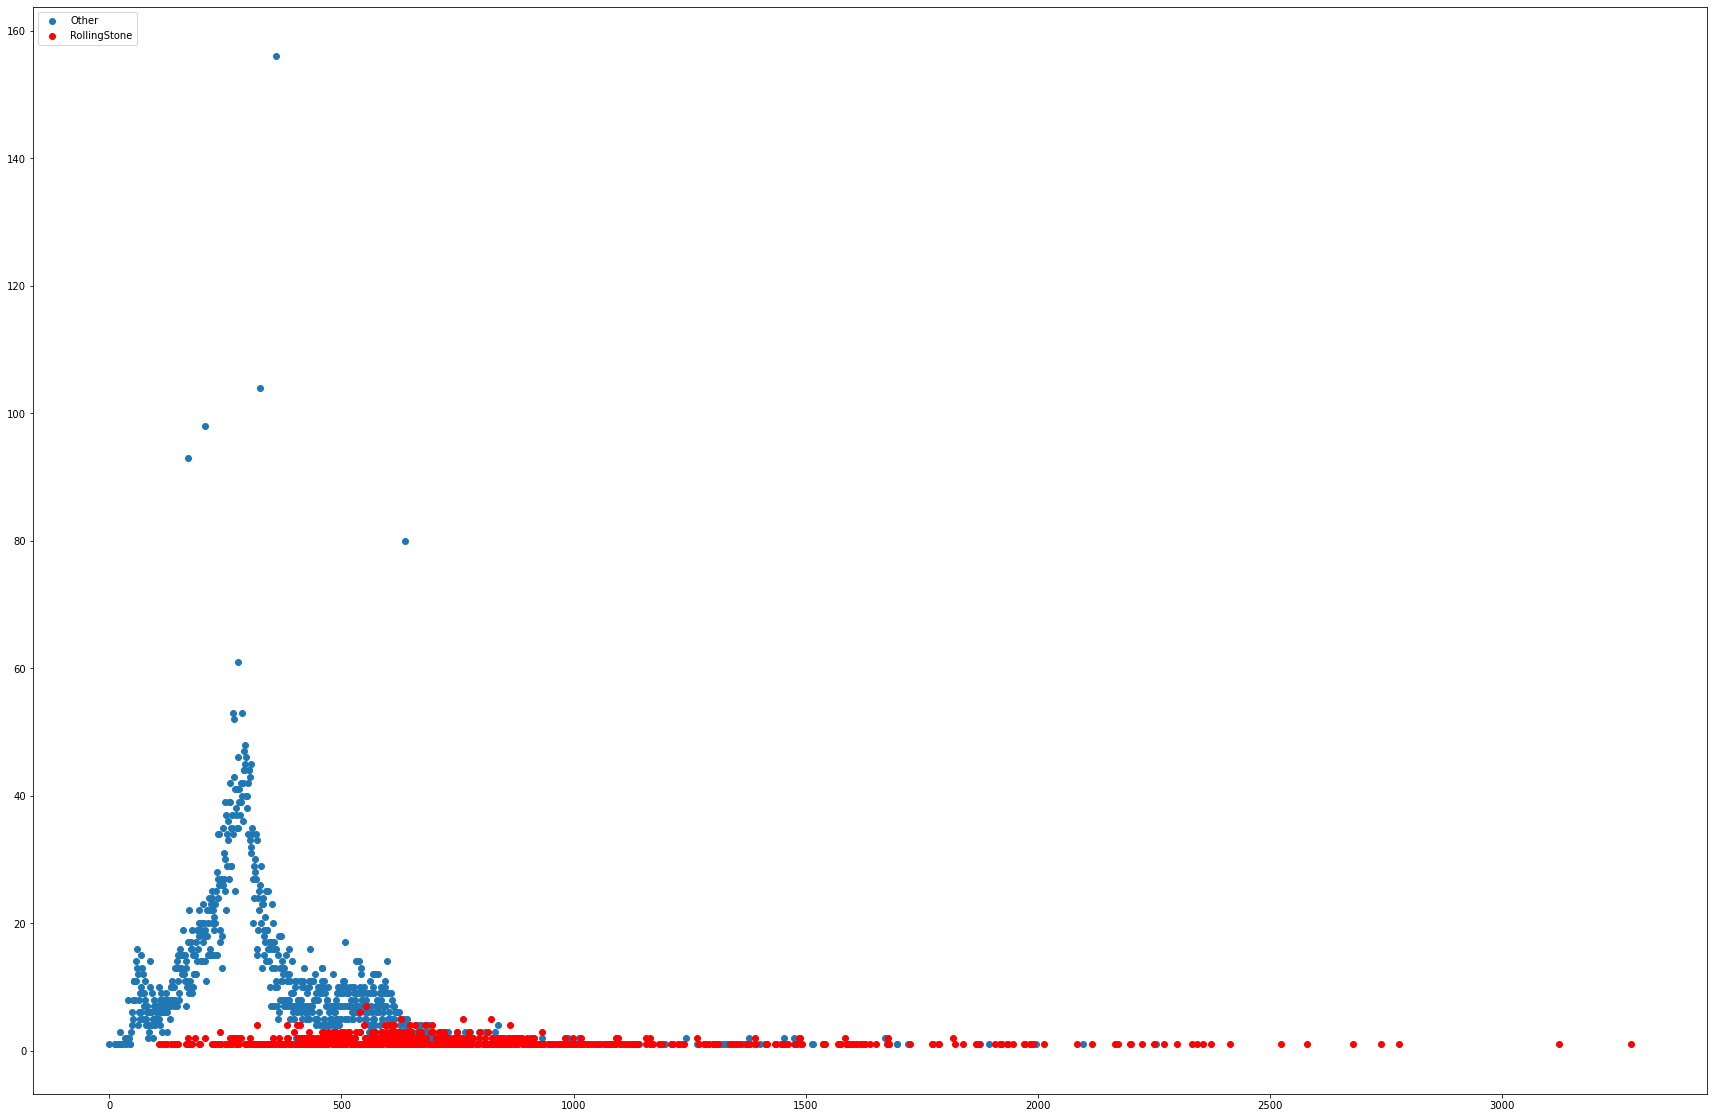

In [105]:
#Unique word counts for rollingstone articles compared to rest of adv_data
rolling_word_count_freq = collections.Counter()
rolling_word_count_freq.update(rollingcounts.tolist())
other_word_count_freq = collections.Counter()
other_word_count_freq.update(othercounts.tolist())

fig = plt.figure(figsize=(30,20))
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*other_word_count_freq.most_common()), label="Other")
ax1.scatter(*zip(*rolling_word_count_freq.most_common()), color="red", label="RollingStone")
plt.legend(loc='upper left');
plt.show();

In [97]:
for x,y in rollingcounter.most_common()[:100]:
    final=True
    for j,k in counter.most_common()[:100]:
        if x==j:
            final=False
            break
    if final:
        print(x)

213
549
924
1634
2143
